In [3]:
import pandas as pd
import numpy as np
import tlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X, y, scaler = tlib.load_tfw1(scale=True)

def f1_safe(rf, y, X):
    return f1_score(y, rf.predict(X), zero_division=0)

def compute_scaled_percentage_changes(X_samples, X_adv, scaler, n_rows):
    X_samples_mis = X_samples.loc[X_adv.index]
    X_samples_scaled = pd.DataFrame(scaler.inverse_transform(X_samples_mis), index=X_samples_mis.index, columns=X_samples_mis.columns)
    X_adv_scaled = pd.DataFrame(scaler.inverse_transform(X_adv), index=X_adv.index, columns=X_adv.columns)
    percentage_norms = np.linalg.norm(tlib.percentage_change(X_samples_scaled.to_numpy(), X_adv_scaled.to_numpy()), ord=2, axis=1)
    perturbation_norms = np.linalg.norm(X_samples_mis.to_numpy() - X_adv.to_numpy(), ord=2, axis=1)
    min_indices = percentage_norms.argsort()[:5]
    
    return pd.DataFrame(
        np.c_[tlib.percentage_change(X_samples_scaled.iloc[min_indices], X_adv_scaled.iloc[min_indices]), perturbation_norms[min_indices]],
        index=min_indices,
        columns=X_samples.columns.tolist()+["L2 Norm"],
    )

def evaluate_adversarial_robustness(X, y, scaler, iterations=5, n_samples=100, random_state=None):
    rows = []
    norm_rows = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_samples, y_samples = tlib.stratified_sampling(X_train, y_train, n=n_samples, random_state=random_state)
    
    X_advs = np.empty(X_samples[:0].shape)
    y_advs = np.empty(y_samples[:0].shape)
    
    print("Training classifier...")
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train.to_numpy(), y_train.to_numpy())
    f1_train = f1_safe(rf, y_train, X_train.to_numpy())
    f1_test = f1_safe(rf, y_test, X_test.to_numpy())
    
    print("Generating adversarial examples...")
    X_adv, y_adv, norms = tlib.generate_rf_adversarials(rf, X_samples, y_samples)
    X_advs, y_advs = np.concatenate([X_advs, X_adv]), np.concatenate([y_advs, y_adv])
    f1_adv = f1_safe(rf, y_adv, X_adv.to_numpy())
    
    # Append first row
    rows.append([f1_train, f1_test, "", f1_adv, len(X_adv), norms.mean()])
    norm_rows.append(norms)

    changes = compute_scaled_percentage_changes(X_samples, X_adv, scaler, 5)
    changes.to_csv(f"fin_03_robustness_iterations=10,samples={samples},before_training.csv")
    
    for i in range(iterations):
        print(f"Iteration {i+1}...")
        
        # Adversarial training
        X_merged, y_merged = np.concatenate([X_train.to_numpy(), X_advs]), np.concatenate([y_train, y_advs])
        rf.fit(X_merged, y_merged)
        
        # Computing metrics
        f1_train = f1_safe(rf, y_train, X_train.to_numpy())
        f1_test = f1_safe(rf, y_test, X_test.to_numpy())
        f1_adv_old = f1_safe(rf, y_adv, X_adv.to_numpy())
        
        # Generating adversarial examples
        X_adv, y_adv, norms = tlib.generate_rf_adversarials(rf, X_samples, y_samples)
        X_advs, y_advs = np.concatenate([X_advs, X_adv]), np.concatenate([y_advs, y_adv])
        f1_adv_new = f1_safe(rf, y_adv, X_adv.to_numpy())
        
        rows.append([f1_train, f1_test, f1_adv_old, f1_adv_new, len(X_adv), norms.mean()])
        norm_rows.append(norms)
    
    changes = compute_scaled_percentage_changes(X_samples, X_adv, scaler, 5)
    changes.to_csv(f"fin_03_robustness_iterations=10,samples={samples},after_training.csv")
    
    return rows, norm_rows

norms_data = {}
for samples in [100, 1000, 10000]:
    print(f"Evaluation robustness using {samples} samples")
    
    # Assess robustness
    rows, norms = evaluate_adversarial_robustness(X, y, scaler, iterations=10, n_samples=samples, random_state=42)

    # Print results table
    table = pd.DataFrame(rows, columns=[
        "F1 (train)",
        "F1 (test)",
        "F1 (adv prev)",
        "F1 (adv new)",
        "Adv count",
        "L2 Norm",
    ])
    tlib.print_df(table)
    
    table.to_csv(f"fin_03_robustness_iterations=10,samples={samples}.csv")
    norms_data[samples] = norms

norm_rows = []
for samples in norms_data:
    for iteration, norms in enumerate(norms_data[samples]):
        for norm in norms:
            norm_rows.append([samples, iteration, norm])

table = pd.DataFrame(norm_rows, columns=[
    "Samples",
    "Iteration",
    "Norm",
])
table.to_csv(f"fin_03_robustness_norms.csv")

Evaluation robustness using 100 samples
Training classifier...
Generating adversarial examples...
Iteration 1...                                  
Iteration 2...                                  
Iteration 3...                                   
Iteration 4...                                  
Iteration 5...                                  
Iteration 6...                                  
Iteration 7...                                  
Iteration 8...                                  
Iteration 9...                                  
Iteration 10...                                 


,F1 (train),F1 (test),F1 (adv prev),F1 (adv new),Adv count,L2 Norm
0,0.999634,0.970213,,0.0,100,0.030395
1,0.999634,0.973126,1.0,0.0,100,0.038079
2,0.999634,0.973126,1.0,0.0,100,0.045744
3,0.999634,0.971671,1.0,0.0,99,0.039121
4,0.999634,0.968750,1.0,0.0,100,0.044793
5,0.999634,0.970213,1.0,0.0,99,0.051759
6,0.999634,0.971671,1.0,0.0,100,0.045717
7,0.999634,0.970213,1.0,0.0,99,0.079523
8,0.999634,0.965812,1.0,0.0,99,0.071270
9,0.999634,0.967283,1.0,0.0,100,0.117077


Evaluation robustness using 1000 samples
Training classifier...
Generating adversarial examples...
Iteration 1...                                    
Iteration 2...                                     
Iteration 3...                                    
Iteration 4...                                     
Iteration 5...                                    
Iteration 6...                                    
Iteration 7...                                     
Iteration 8...                                    
Iteration 9...                                    
Iteration 10...                                   


,F1 (train),F1 (test),F1 (adv prev),F1 (adv new),Adv count,L2 Norm
0,0.999634,0.970213,,0.0,999,0.028005
1,0.999634,0.970213,1.0,0.0,997,0.036025
2,0.999634,0.962857,1.0,0.0,997,0.039689
3,0.999634,0.962857,1.0,0.0,996,0.031003
4,0.999634,0.961373,1.0,0.0,997,0.033317
5,0.999634,0.962857,1.0,0.0,997,0.036080
6,0.999634,0.961373,1.0,0.0,996,0.036509
7,0.999634,0.958393,1.0,0.0,996,0.040172
8,0.999634,0.961263,1.0,0.0,998,0.040861
9,0.999634,0.959885,1.0,0.0,997,0.041519


Evaluation robustness using 10000 samples
Training classifier...
Generating adversarial examples...
Iteration 1...                                      
Iteration 2...                                       
Iteration 3...                                      
Iteration 4...                                      
Iteration 5...                                      
Iteration 6...                                      
Iteration 7...                                       
Iteration 8...                                      
Iteration 9...                                      
Iteration 10...                                     


,F1 (train),F1 (test),F1 (adv prev),F1 (adv new),Adv count,L2 Norm
0,0.999634,0.970213,,0.0000,9994,0.028103
1,0.999634,0.964337,1.0,0.0000,9984,0.027327
2,0.999634,0.962963,1.0,0.0000,9978,0.035167
3,0.999634,0.965812,1.0,0.0002,9983,0.035824
4,0.999634,0.965812,1.0,0.0000,9984,0.030593
5,0.999634,0.965812,1.0,0.0000,9981,0.040452
6,0.999634,0.961373,1.0,0.0000,9975,0.039779
7,0.999634,0.955396,1.0,0.0000,9984,0.044213
8,0.999634,0.955396,1.0,0.0000,9970,0.031595
9,0.999634,0.953890,1.0,0.0000,9962,0.033190


n=100
2.084769168061904
0.0030196401387535543
n=1000
1.8236817801870095
0.009110759731947748
n=10000
1.7584729027756731
0.015271992931970124


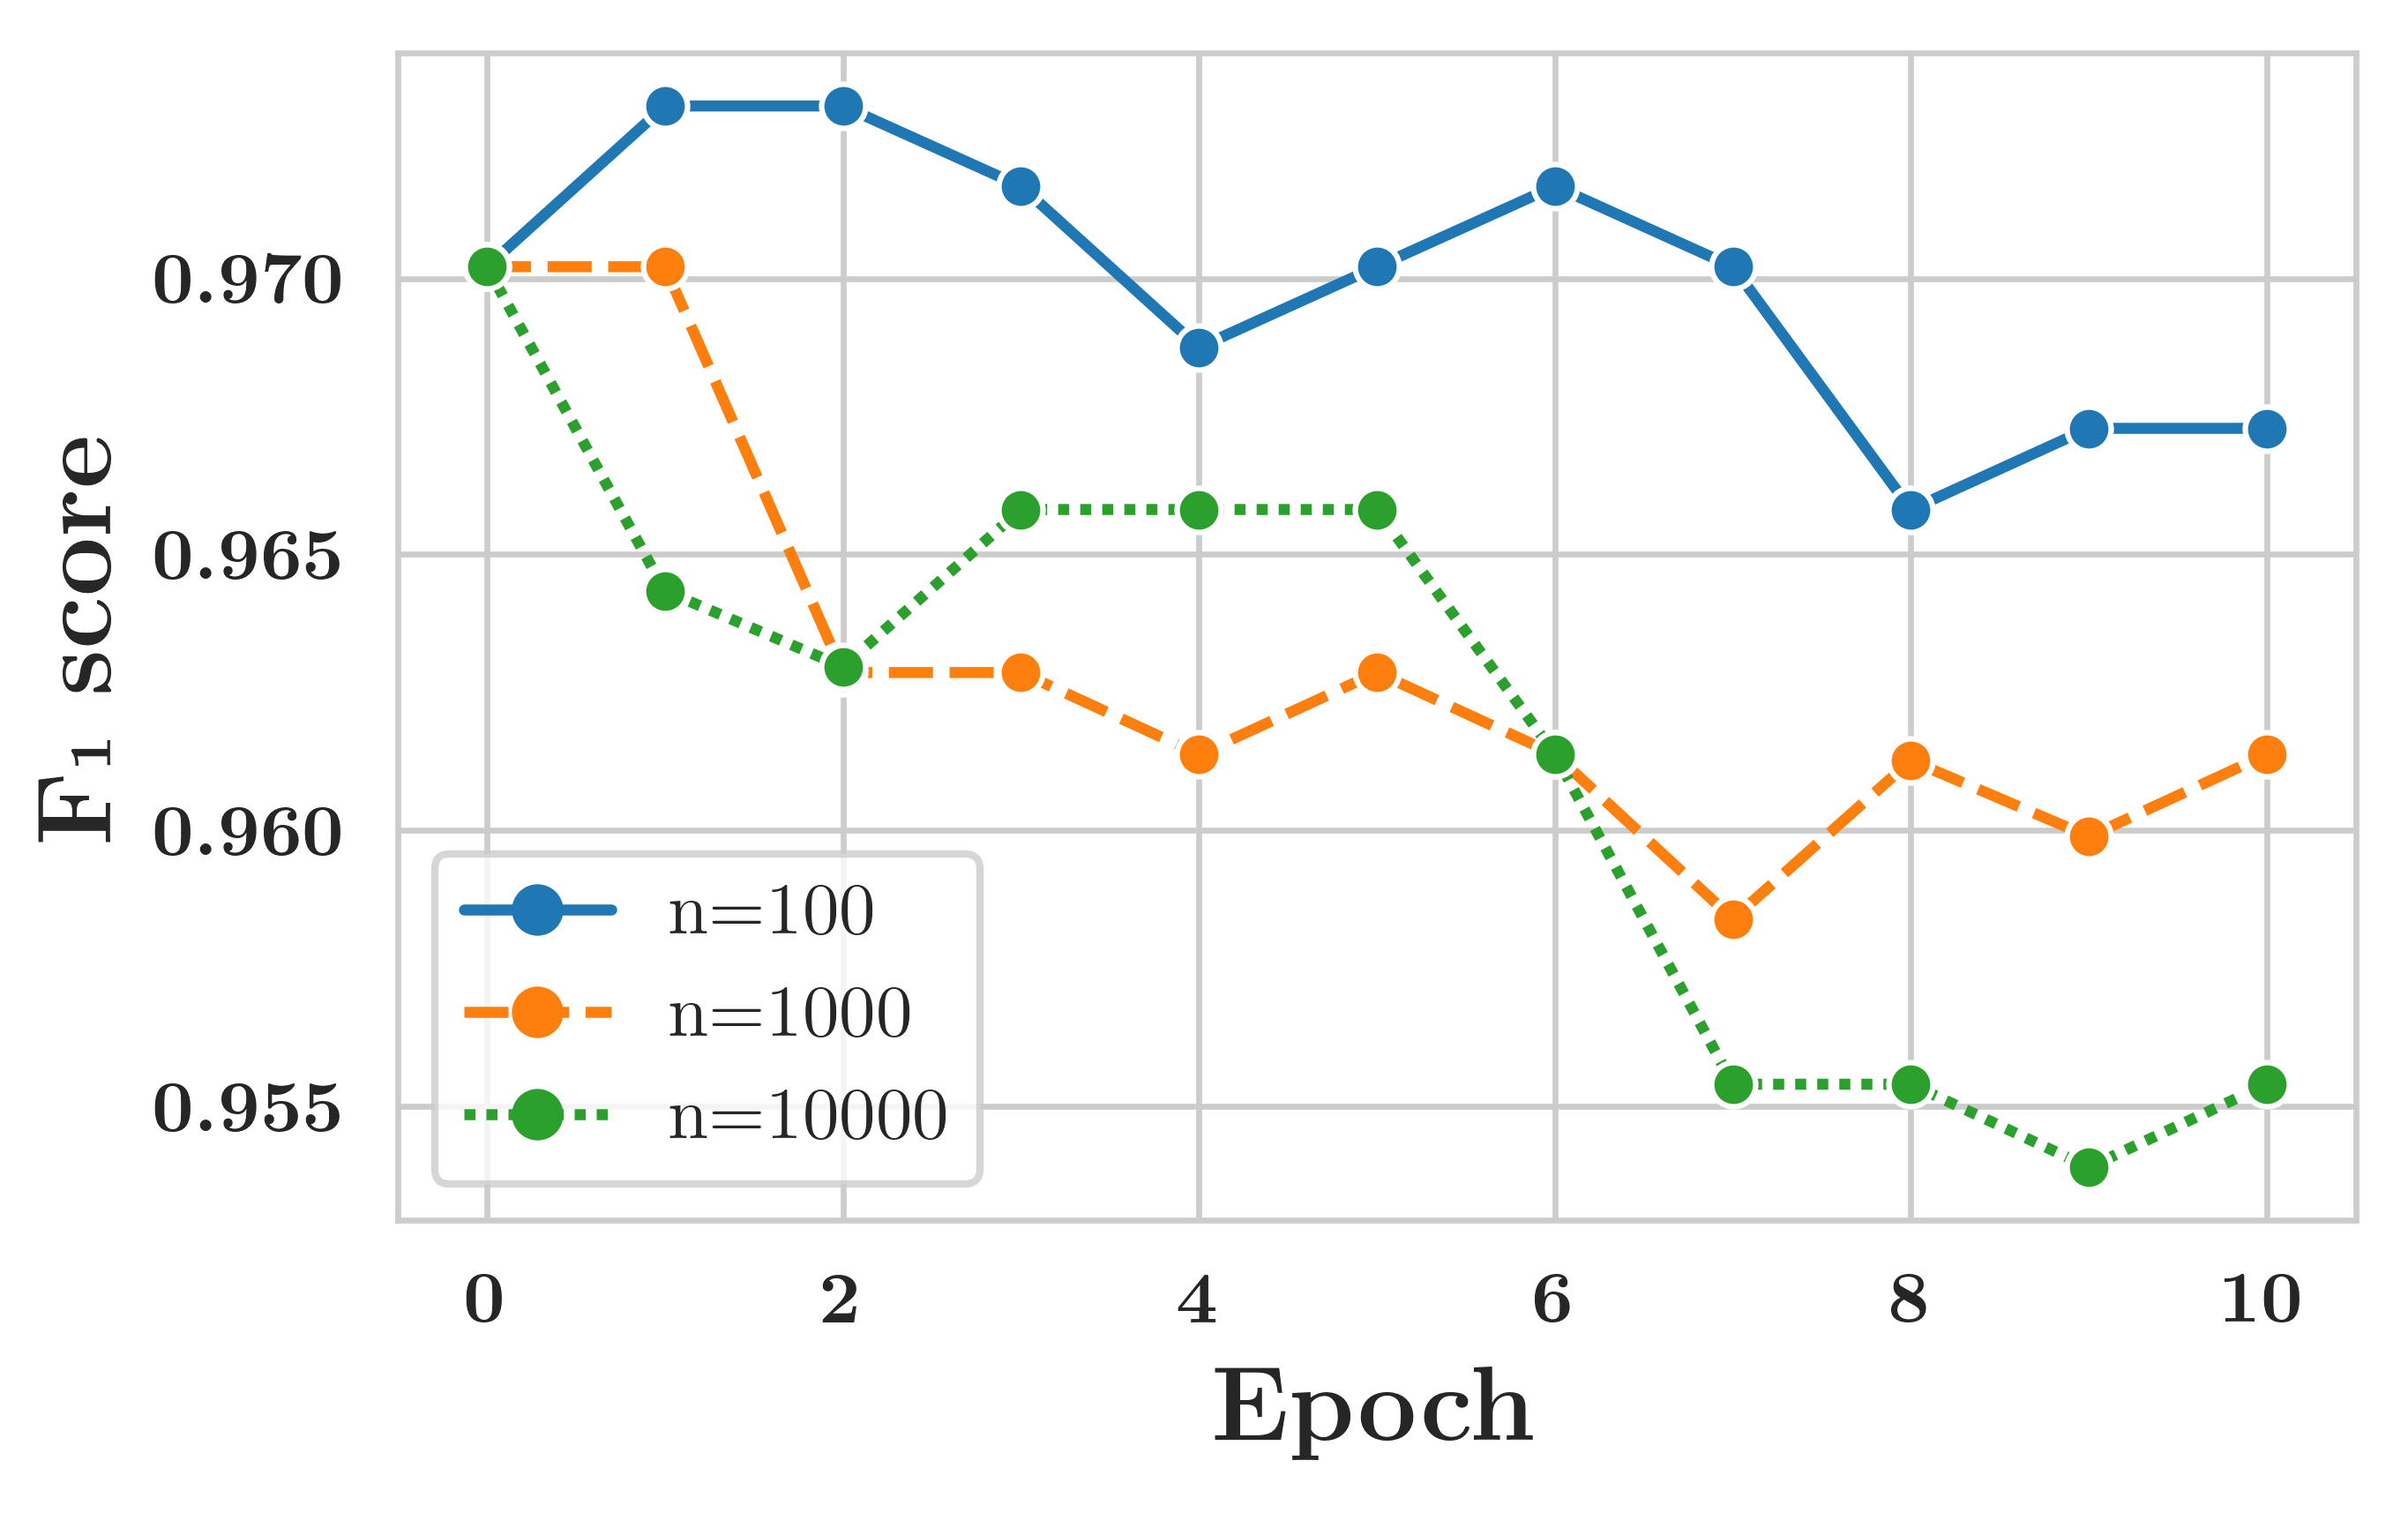

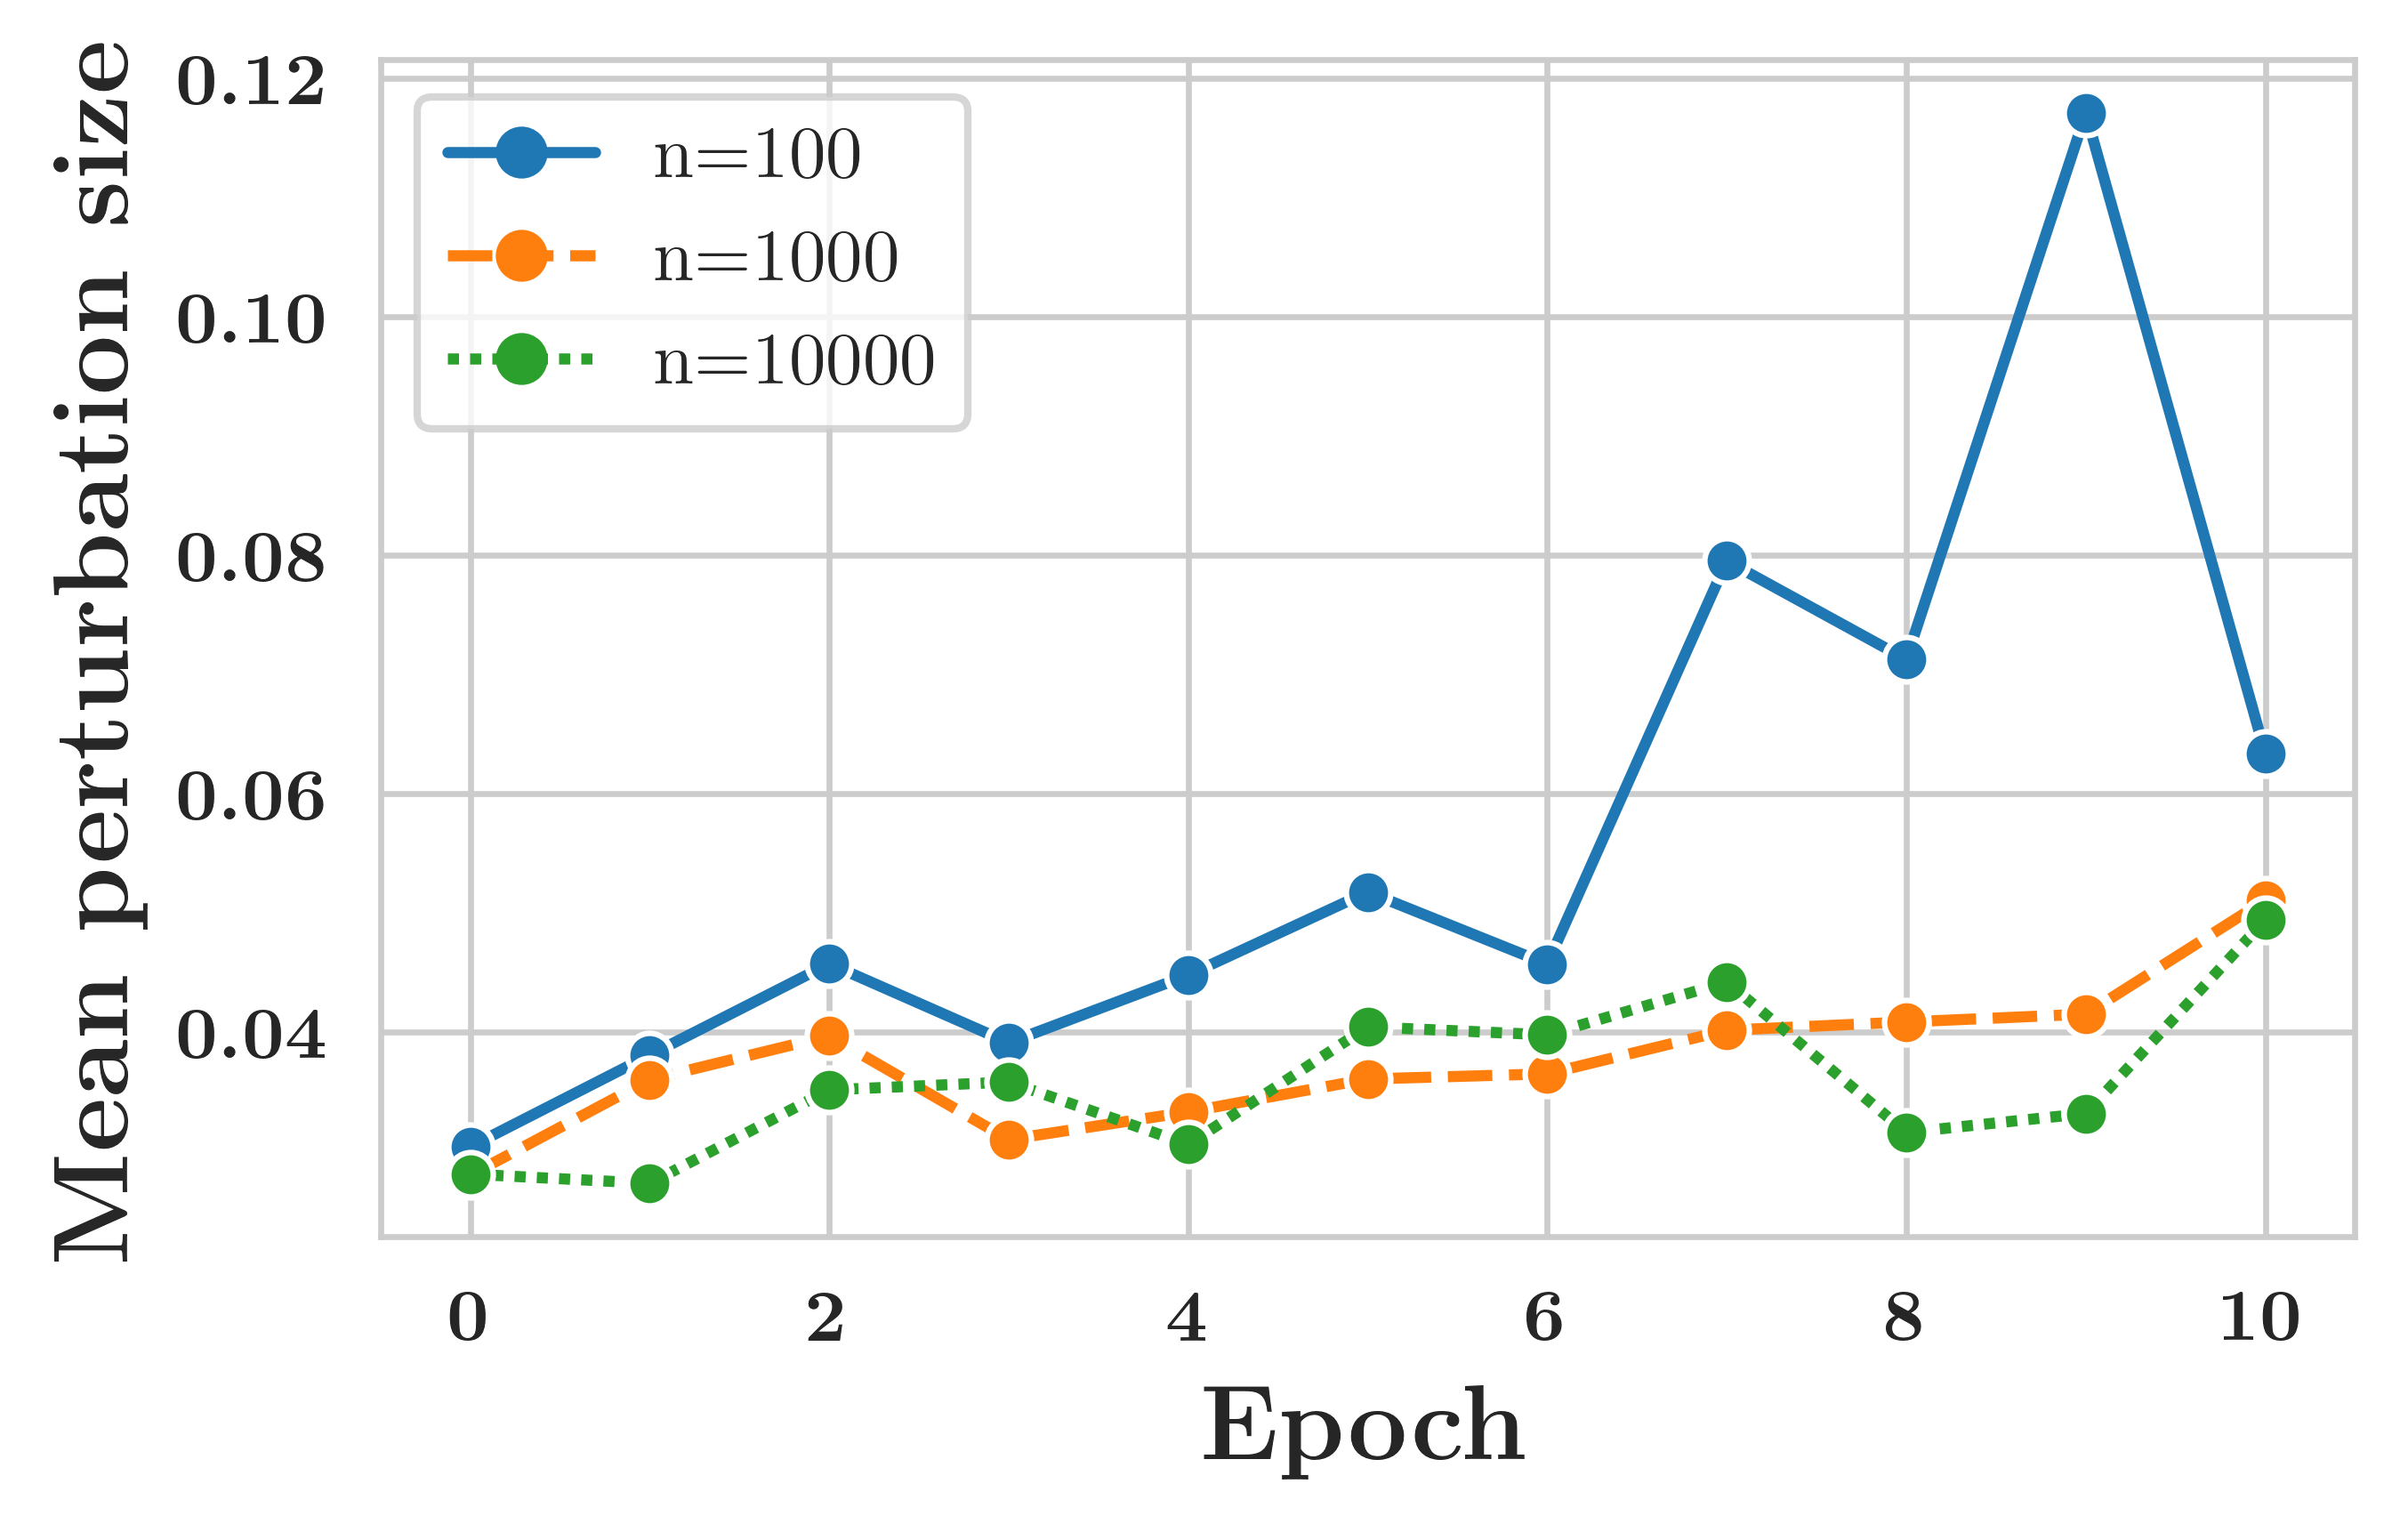

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Borrowed from https://stackoverflow.com/a/31527287/2102808
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                   Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                           using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

df_100 = pd.read_csv("fin_03_robustness_iterations=10,samples=100.csv", index_col=0)
df_1000 = pd.read_csv("fin_03_robustness_iterations=10,samples=1000.csv", index_col=0)
df_10000 = pd.read_csv("fin_03_robustness_iterations=10,samples=10000.csv", index_col=0)

df_f1 = pd.DataFrame(np.c_[df_100["F1 (test)"], df_1000["F1 (test)"], df_10000["F1 (test)"]], columns=["n=100", "n=1000", "n=10000"])
df_norm = pd.DataFrame(np.c_[df_100["L2 Norm"], df_1000["L2 Norm"], df_10000["L2 Norm"]], columns=["n=100", "n=1000", "n=10000"])

print("n=100")
print(df_100.iloc[10]["L2 Norm"] / df_100.iloc[0]["L2 Norm"])
print(1 - df_100.iloc[10]["F1 (test)"] / df_100.iloc[0]["F1 (test)"])

print("n=1000")
print(df_1000.iloc[10]["L2 Norm"] / df_1000.iloc[0]["L2 Norm"])
print(1 - df_1000.iloc[10]["F1 (test)"] / df_1000.iloc[0]["F1 (test)"])

print("n=10000")
print(df_10000.iloc[10]["L2 Norm"] / df_10000.iloc[0]["L2 Norm"])
print(1 - df_10000.iloc[10]["F1 (test)"] / df_10000.iloc[0]["F1 (test)"])

sns.set_style("whitegrid")

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "10"
plt.rcParams["text.latex.preamble"] = r"\boldmath"

plt.figure(figsize=get_figsize(345, wf=1.0, hf=0.6), dpi=600)
gfg = sns.lineplot(data=df_f1, markers=["o", "o", "o"])
gfg.set(xlabel=r"\Large{\textbf{Epoch}}", ylabel=r"\Large{\textbf{F\footnotesize{1}\Large{ score}}}")
plt.savefig("fin_03_test_f1.png", bbox_inches="tight")

plt.figure(figsize=get_figsize(345, wf=1.0, hf=0.6), dpi=600)
gfg = sns.lineplot(data=df_norm, markers=["o", "o", "o"])
gfg.set(xlabel=r"\Large{\textbf{Epoch}}", ylabel=r"\Large{\textbf{Mean perturbation size}}")
plt.savefig("fin_03_mean_perturbation_size.png", bbox_inches="tight")